In [1]:
# !sudo apt install -y fluidsynth

!pip install --upgrade pyfluidsynth
!pip install pretty_midi

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

2022-12-02 19:43:55.637637: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-02 19:43:55.818358: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-02 19:43:56.458736: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-02 19:43:56.458857: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [3]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

In [4]:
data_dir = pathlib.Path('maestro-v3.0.0')
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1276


## Process a midi file

First, use pretty_midi to parse a single MIDI file and inspect the format of the notes.

In [5]:
sample_file = filenames[1]
print(sample_file)

# Generate a PrettyMIDI object for the sample MIDI file.
pm = pretty_midi.PrettyMIDI(sample_file)

# Play the sample file
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

display_audio(pm)

maestro-v3.0.0/2018/MIDI-Unprocessed_Recital17-19_MID--AUDIO_19_R1_2018_wav--6.midi


fluidsynth: error: Unknown integer parameter 'synth.sample-rate'


In [6]:
# some inspection on the MIDI file. What kinds of instruments are used?
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


## Extract notes

In [7]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=22, note_name=A#0, duration=0.0964
1: pitch=34, note_name=A#1, duration=0.1159
2: pitch=41, note_name=F2, duration=0.1185
3: pitch=46, note_name=A#2, duration=0.1836
4: pitch=50, note_name=D3, duration=0.1068
5: pitch=52, note_name=E3, duration=0.0378
6: pitch=53, note_name=F3, duration=0.1211
7: pitch=62, note_name=D4, duration=0.0977
8: pitch=58, note_name=A#3, duration=0.1263
9: pitch=55, note_name=G3, duration=0.1289


In [8]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [9]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,22,0.955729,1.052083,0.000000,0.096354
1,34,0.962240,1.078125,0.006510,0.115885
2,41,1.299479,1.417969,0.337240,0.118490
3,46,1.423177,1.606771,0.123698,0.183594
4,50,1.531250,1.638021,0.108073,0.106771


In [10]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['A#0', 'A#1', 'F2', 'A#2', 'D3', 'E3', 'F3', 'A#3', 'D4', 'G3'],
      dtype='<U3')

In [11]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

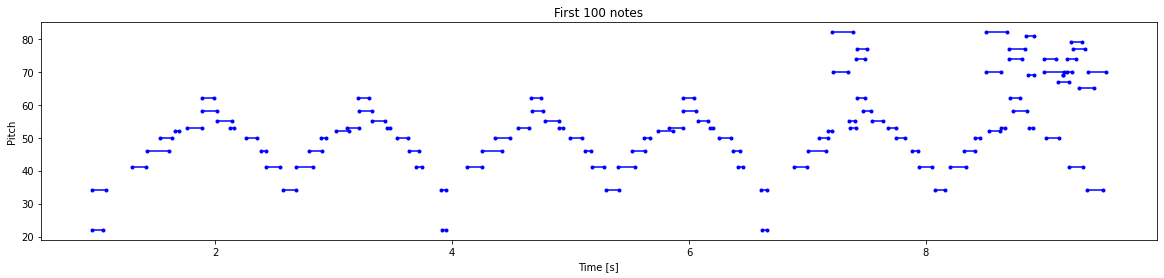

In [12]:
plot_piano_roll(raw_notes, count=100)

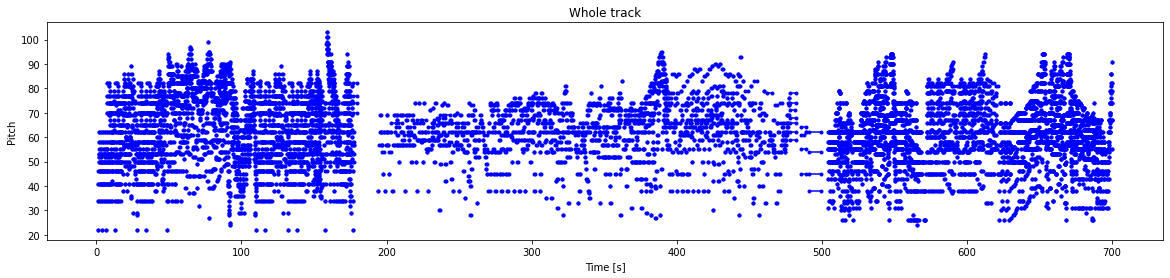

In [13]:
plot_piano_roll(raw_notes)

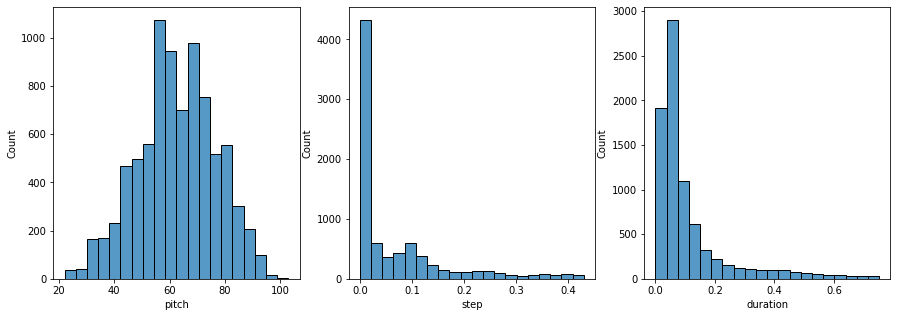

In [14]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

plot_distributions(raw_notes)

## Create a MIDI file

We can generate your own MIDI file from a list of notes using the function below.

In [15]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [16]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

In [17]:
display_audio(example_pm)

fluidsynth: error: Unknown integer parameter 'synth.sample-rate'


## Create the training dataset

Create the training dataset by extracting notes from the MIDI files. You can start by using a small number of files, and experiment later with more. This may take a couple minutes.

In [18]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [19]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 52235


In [20]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

2022-12-02 19:44:26.186430: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-02 19:44:26.186858: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-12-02 19:44:26.186935: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-12-02 19:44:26.187004: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2022-12-02 19:44:26.187074: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could no

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [21]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [22]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [23]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[5.54687500e-01 0.00000000e+00 3.05338542e+00]
 [4.60937500e-01 5.20833333e-03 1.72916667e+00]
 [5.23437500e-01 0.00000000e+00 2.95703125e+00]
 [3.90625000e-01 1.95312500e-02 1.74348958e+00]
 [3.35937500e-01 2.60416667e-03 1.69401042e+00]
 [5.39062500e-01 2.92968750e+00 5.01302083e-01]
 [4.68750000e-01 1.69270833e-02 7.29166667e-02]
 [3.90625000e-01 1.30208333e-02 8.20312500e-02]
 [5.15625000e-01 5.20833333e-03 3.12500000e-01]
 [3.35937500e-01 3.90625000e-03 7.68229167e-02]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=50.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.44270833333333304>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.16276041666666696>}


In [24]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

## Create and train the model

The model will have three outputs, one for each note variable. For step and duration, you will use a custom loss function based on mean squared error that encourages the model to output non-negative values.

In [25]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [26]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 128)          67584       ['input_1[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm[0][0]']                   
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm[0][0]']                   
                                                                                              

In [27]:
losses = model.evaluate(train_ds, return_dict=True)
losses

815/815 [==============================] - 14s 10ms/step - loss: 5.8126 - duration_loss: 0.6270 - pitch_loss: 4.8520 - step_loss: 0.3336


{'loss': 5.812558650970459,
 'duration_loss': 0.6269506812095642,
 'pitch_loss': 4.852041244506836,
 'step_loss': 0.33356642723083496}

In [28]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [29]:
model.evaluate(train_ds, return_dict=True)

815/815 [==============================] - 9s 11ms/step - loss: 1.2031 - duration_loss: 0.6270 - pitch_loss: 4.8520 - step_loss: 0.3336


{'loss': 1.2031190395355225,
 'duration_loss': 0.6269506812095642,
 'pitch_loss': 4.852041244506836,
 'step_loss': 0.33356642723083496}

In [30]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [32]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
815/815 [==============================] - 15s 19ms/step - loss: 0.3181 - duration_loss: 0.0625 - pitch_loss: 3.7821 - step_loss: 0.0665
Epoch 2/50
815/815 [==============================] - 31s 39ms/step - loss: 0.3068 - duration_loss: 0.0608 - pitch_loss: 3.7703 - step_loss: 0.0574
Epoch 3/50
815/815 [==============================] - 23s 29ms/step - loss: 0.2989 - duration_loss: 0.0601 - pitch_loss: 3.7609 - step_loss: 0.0509
Epoch 4/50
815/815 [==============================] - 24s 29ms/step - loss: 0.2984 - duration_loss: 0.0607 - pitch_loss: 3.7599 - step_loss: 0.0497
Epoch 5/50
815/815 [==============================] - 23s 29ms/step - loss: 0.2973 - duration_loss: 0.0596 - pitch_loss: 3.7732 - step_loss: 0.0490
Epoch 6/50
815/815 [==============================] - 24s 30ms/step - loss: 0.2953 - duration_loss: 0.0602 - pitch_loss: 3.7631 - step_loss: 0.0470
Epoch 7/50
815/815 [==============================] - 23s 29ms/step - loss: 0.3076 - duration_loss: 0.0605 - pit

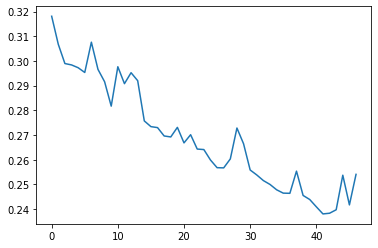

In [34]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

## Generate notes

To use the model to generate notes, you will first need to provide a starting sequence of notes. The function below generates one note from a sequence of notes.

For note pitch, it draws a sample from the softmax distribution of notes produced by the model, and does not simply pick the note with the highest probability. Always picking the note with the highest probability would lead to repetitive sequences of notes being generated.

The temperature parameter can be used to control the randomness of notes generated.

In [36]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [37]:
temperature = 2.0
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 20ms/step


In [38]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,57,0.061873,0.174370,0.061873,0.236243
1,71,0.000000,0.130201,0.061873,0.192074
2,70,0.000000,0.194910,0.061873,0.256783
3,48,0.000000,0.214122,0.061873,0.275995
4,56,0.000000,0.000000,0.061873,0.061873
5,48,0.000000,0.068827,0.061873,0.130700
6,47,0.000000,0.000000,0.061873,0.061873
7,61,0.000000,0.000000,0.061873,0.061873
8,40,0.000000,0.148965,0.061873,0.210838
9,61,0.000000,0.000000,0.061873,0.061873


In [39]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

fluidsynth: error: Unknown integer parameter 'synth.sample-rate'


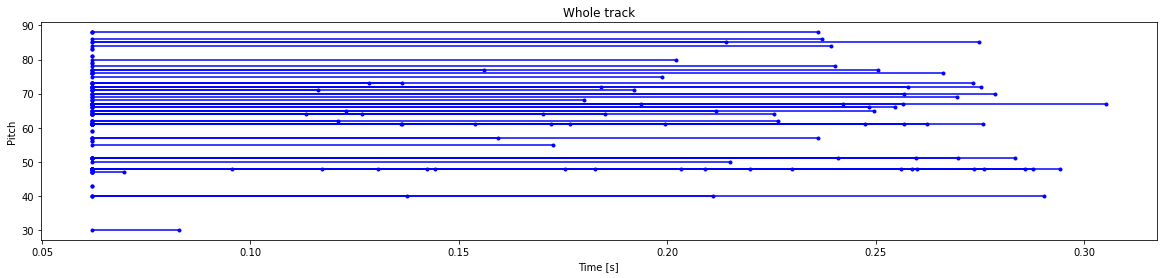

In [40]:
plot_piano_roll(generated_notes)

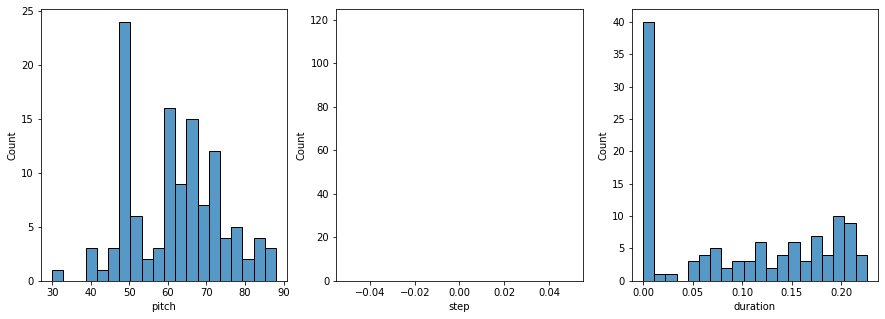

In [41]:
plot_distributions(generated_notes)